# ECE 689, Spring 2025
## Homework 4

## Full name: Mehak Arora

## Question 1: Undirect Graphical Model (UGM)

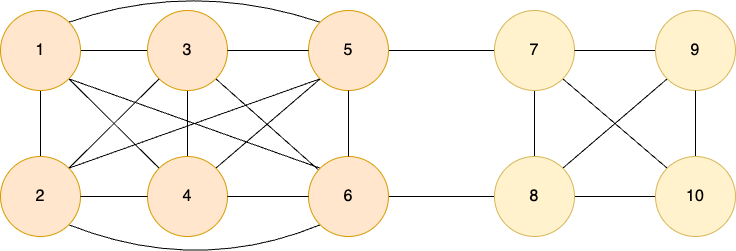


Consider a graph with 10 nodes of real random variables (i.e., $x_1, x_2,...,x_{10}$), where the maximal cliques are given as: $C_1=\{x_1, x_2, x_3, x_4, x_5, x_6\}$, $C_2: =\{x_7,x_8,x_9,x_{10}\}$, $C_3={x_5, x_7}$, $C_4 = \{x_6, x_8\}$ (See figure above).

That is, $(x_1, x_2,...,x_6)$ are fully-connected and the potential functions are given as follows:
$$\phi_{C_1}(x_1, x_2,...,x_6) = \exp(-[x_1, x_2,...,x_6] \Sigma^{-1}[x_1, x_2,...,x_6]^T)$$
where
$$\Sigma =
\begin{bmatrix} 
2 & 0.5 & 0.2 & 0.5 & 0.5 & 0.2\\
0.5 & 2 & 0.8 & 0.8 & 0.5 & 0.5\\
0.2 & 0.8 & 1 & 0.2 & 0.1 & 0.1\\
0.5 & 0.8 & 0.2 & 1 & 0.5 & 0.5\\
0.5 & 0.5 & 0.1 & 0.5 & 2 & 0.8\\
0.2 & 0.5 & 0.1 & 0.5 & 0.8 & 2
\end{bmatrix}
$$
Similarly, $(x_7, x_8, x_9, x_{10})$ are fully-connected and the potential functions are given as follows:
$$\phi_{C_2}(x_7, x_8, x_9, x_{10}) = \exp(\Sigma_{i=7}^{10} x_i^4 - \Sigma_{7 \leq i<j \leq 10} x_i^2 x_j^2)$$

Additionally, node 5 and 7 are connected and $\phi_{C_3}(x_5,x_7) = \exp(-x_5^4 x_7^6)$.
And node 6 and node 8 are connected and $\phi_{C_4}(x_6,x_8) = \exp(-x_6^2 x_8^8)$.

(i) Sample 100,000 data points from the pdf of the graphical model $p(x) \propto \prod \phi(x_i)$, where $x$ is real.

(ii) Assume only the samples are given and the potential functions are not known, train neural networks using the above generated data and estimate the energy and the potential function for each maximal clique.


In [58]:
import torch
import random
import numpy as np
import time

import clique_potentials
import LangevinDynamics as ld
import importlib
importlib.reload(clique_potentials)

<module 'clique_potentials' from '/hpc/home/ma618/ADL/HW4/clique_potentials.py'>

Running Langevin dynamics on cuda...


Step 9900, Avg Energy: -6.8315: 100%|██████████| 10000/10000 [01:09<00:00, 144.40it/s]


Sampling completed in 69.32 seconds.


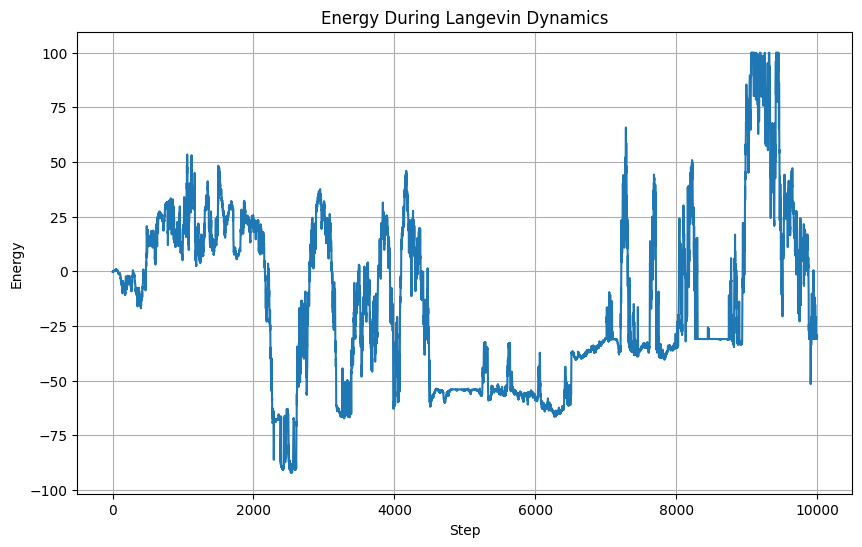

In [59]:
n_samples = 100000  
n_dims = 10        
n_steps = 10000     
step_size = 0.001  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Running Langevin dynamics on {device}...")

start_time = time.time()
samples, energy_history = ld.langevin_dynamics(
    energy_fn=ld.clipped_energy,  
    n_samples=n_samples,
    n_dims=n_dims,
    n_steps=n_steps,
    step_size=step_size,
    device=device,
    verbose=True,
    max_grad_norm=0.5  # Limit the gradient norm
)
end_time = time.time()

print(f"Sampling completed in {end_time - start_time:.2f} seconds.")

# Plot energy history
energy_fig = ld.plot_energy_history(energy_history)

# Save results
#np.save("langevin_samples.npy", samples.cpu().numpy())

In [3]:
import GNN
import torch
import numpy as np
import importlib
import torch.optim as optim
from tqdm import tqdm


importlib.reload(GNN)

/hpc/dctrl/ma618/torch/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


<module 'GNN' from '/hpc/home/ma618/ADL/HW4/GNN.py'>

In [4]:
samples = np.load("langevin_samples.npy")

In [5]:
samples.shape

(100000, 10)

In [6]:
cliques = [
        [0, 1, 2, 3, 4, 5],  # C1: x1 to x6
        [6, 7, 8, 9],        # C2: x7 to x10
        [4, 6],              # C3: x5, x7
        [5, 7]               # C4: x6, x8
    ]

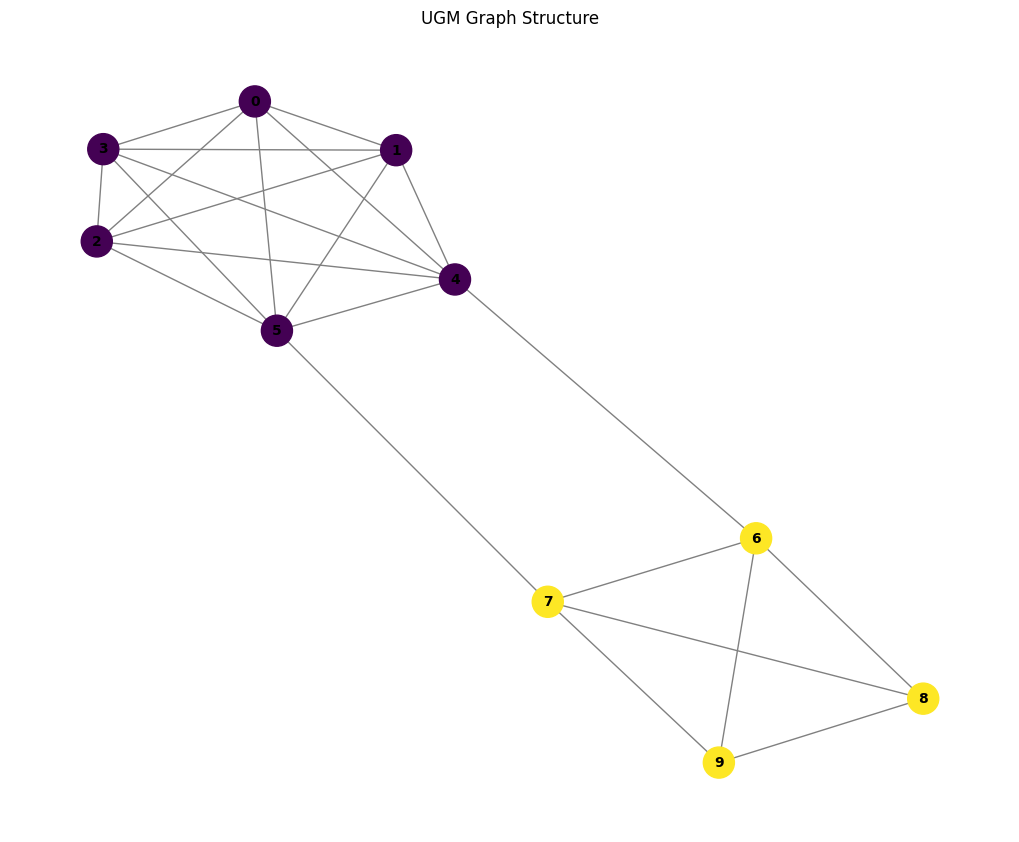

In [7]:
edge_index = GNN.prepare_graph_from_cliques(10, cliques)
G = GNN.create_networkx_graph(10, edge_index, cliques)
graph_viz = GNN.visualize_graph(G)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
# Convert samples to PyTorch tensors
samples_tensor = torch.FloatTensor(samples)

batch_size = 64
# Prepare data loader
dataset = torch.utils.data.TensorDataset(samples_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Create graph structure
num_nodes = samples.shape[1]
edge_index = GNN.prepare_graph_from_cliques(num_nodes, cliques)
edge_index = edge_index.to(device)

In [9]:
hidden_dim = 64
lr = 0.001
gnn_layers = 3
weight_decay = 1e-5
conv_type = 'gcn'
verbose = True
noise_type = 'gaussian'
noise_scale = 0.3

model = GNN.UGMPotentialModel(num_nodes, cliques, hidden_dim, gnn_layers, 
                              hidden_dim//2, conv_type).to(device)
    
# Optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                factor=0.5, patience=20,
                                                verbose=verbose)

/hpc/dctrl/ma618/torch/lib64/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [10]:
losses = []
    
epochs = 50
clip_grad = 1.0
iterator = tqdm(range(epochs))
for epoch in iterator:
    model.train()
    epoch_losses = []

    for batch_idx, (batch_data,) in enumerate(dataloader):
        batch_data = batch_data.to(device)

        # Generate noise samples based on specified noise type
        if noise_type == 'gaussian':
            noise_samples = batch_data + noise_scale * torch.randn_like(batch_data).to(device)
        elif noise_type == 'uniform':
            noise_samples = batch_data + noise_scale * (torch.rand_like(batch_data) * 2 - 1).to(device)
        elif noise_type == 'shuffle':
            # Shuffle each variable independently
            noise_samples = batch_data.clone()
            for i in range(noise_samples.shape[1]):
                idx = torch.randperm(noise_samples.shape[0])
                noise_samples[:, i] = noise_samples[idx, i]
        else:
            raise ValueError(f"Unknown noise type: {noise_type}")

        # Forward pass for real data
        real_energies, real_clique_energies = model(batch_data, edge_index)

        # Forward pass for noise data
        noise_energies, noise_clique_energies = model(noise_samples, edge_index)

        # NCE loss: push down energy of real data, push up energy of noise
        loss = -torch.mean(real_energies) + torch.mean(noise_energies)

        # Add regularization to encourage balanced contributions from each clique
        clique_balance_reg = 0.0
        for i in range(len(real_clique_energies)):
            for j in range(i+1, len(real_clique_energies)):
                clique_balance_reg += torch.abs(
                    torch.mean(real_clique_energies[i]) - torch.mean(real_clique_energies[j])
                )

        loss += 0.01 * clique_balance_reg

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

        optimizer.step()

        epoch_losses.append(loss.item())

    # Average loss for this epoch
    avg_loss = np.mean(epoch_losses)
    losses.append(avg_loss)

    # Update learning rate
    scheduler.step(avg_loss)

    iterator.set_description(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 50/50, Loss: -70995961909644935168.0000: 100%|██████████| 50/50 [26:21<00:00, 31.63s/it]


In [ ]:
torch.save(model.state_dict(), "ugm_model.pth")

Text(0.5, 1.0, 'Training Loss')

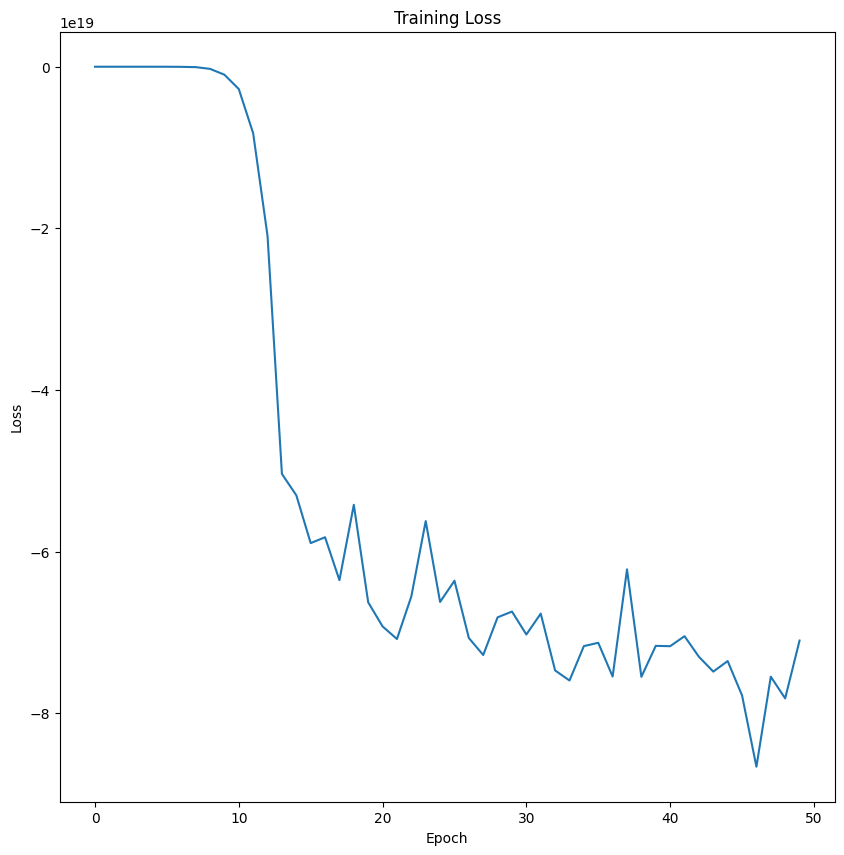

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

## Generate Samples from the Learned Model

In [12]:
num_gen_samples = 100000
model.eval()
    
# Initialize random samples
gen_samples = torch.randn(num_gen_samples, model.num_nodes).to(device)

# Run Langevin dynamics
num_steps = 1000
step_size = 0.1
energy= []
iterator = tqdm(range(num_steps), desc="Generating samples")
for step in iterator:
    # Add noise
    noise = torch.randn_like(gen_samples) * np.sqrt(2 * step_size)

    # Compute energy gradient
    gen_samples.requires_grad_(True)
    energy, _ = model(gen_samples, edge_index)
    total_energy = torch.sum(energy)
    

    # Compute gradients
    grad = torch.autograd.grad(total_energy, gen_samples)[0]
    
    # Update samples using gradients
    with torch.no_grad():
        grad_norm = torch.norm(grad, dim=1, keepdim=True)
        scaled_grad = grad * torch.clamp(1.0 / (grad_norm + 1e-6), max=1.0)
        gen_samples = gen_samples - step_size * scaled_grad + noise
        gen_samples = torch.clamp(gen_samples, -10.0, 10.0)
    iterator.set_description(f"Energy: {total_energy}")
    

Generating samples: 100%|██████████| 1000/1000 [18:43<00:00,  1.12s/it]


In [15]:
model.eval()
    
# Convert true samples to tensor
true_samples = samples_tensor
true_samples = true_samples.to(device)
generated_samples = gen_samples.to(device)

with torch.no_grad():
    true_energies, true_clique_energies = model(true_samples, edge_index)
    gen_energies, gen_clique_energies = model(generated_samples, edge_index)

    # Compute average energies
    true_energy_mean = true_energies.mean().item()
    gen_energy_mean = gen_energies.mean().item()

    # Compute energy gap
    energy_gap = np.abs(true_energy_mean - gen_energy_mean)

    # Compare mean and variance of each variable
    true_means = true_samples.mean(dim=0).cpu().numpy()
    gen_means = generated_samples.mean(dim=0).cpu().numpy()

    true_vars = true_samples.var(dim=0).cpu().numpy()
    gen_vars = generated_samples.var(dim=0).cpu().numpy()

    mean_error = np.mean(np.abs(true_means - gen_means))
    var_error = np.mean(np.abs(true_vars - gen_vars))
    

In [16]:
print("true_energy_mean: ", true_energy_mean)
print("gen_energy_mean: ", gen_energy_mean)
print("energy_gap: ",energy_gap)
print("mean_error: ", mean_error)
print("var_error: ", var_error)
print("true_means: ", true_means)
print("gen_means: ", gen_means)
print("true_vars: ", true_vars)
print("gen_vars: ", gen_vars)

true_energy_mean:  -2.9774290180264184e+22
gen_energy_mean:  -6.393395599408076e+22
energy_gap:  3.4159665813816577e+22
mean_error:  0.008324373
var_error:  45.97883
true_means:  [ 0.00857383  0.01108989  0.00106236  0.01187335  0.00024737 -0.00523835
 -0.0035788   0.0206727  -0.01314219 -0.01351435]
gen_means:  [-0.00395919  0.02012294 -0.00692393 -0.00831614  0.00241141  0.00201332
 -0.0099096   0.01806277 -0.0038384  -0.00767273]
true_vars:  [17.993656 18.030294 17.893003 17.796585 17.513323 17.856155 18.379114
 18.081024 19.392662 19.259706]
gen_vars:  [64.01339  64.363846 64.28227  64.120155 64.18135  64.137375 64.38294
 64.08993  64.25241  64.16015 ]


## Question 2: Implementing Physics Informed Neural Networks (PINNs)

**Objective**: Implement and analyze a Physics-Informed Neural Network (PINN) that uses a two-layer Multilayer Perceptron (MLP) to solve a specified first-order elliptic Partial Differential Equation (PDE) subject to appropriate boundary conditions.


**Background**: Physics-Informed Neural Networks integrate differential equations that govern physical laws directly into the learning process, allowing the network to not only fit given data but also satisfy the known physical laws. PINNs are particularly useful for solving complex PDEs where traditional numerical methods might be challenging to implement.

For this assignment, focus on a first-order elliptic PDE, which is common in various areas of physics and engineering, such as heat transfer, fluid dynamics, and electromagnetism.

You can refer to https://www.sciencedirect.com/science/article/pii/S0021999118307125 for further reading.

We consider the following first-order elliptic PDE over a domain $\Omega$:
$$-\nabla\cdot(a(x)\nabla u(x)) = f(x), x\in\Omega$$
$$u(x) = g(x), x\in\partial \Omega$$

We have $u(x)\in\mathbb{R}, x\in\mathbb{R}^2, a(x) = x^T x$, $f(x) = \sin(x^T x), g(x) = x^T x$, and $\Omega = [0,1]\times[0,1]$ is a unit cube.

PINNs minimize the residual loss given as:

$$\mathcal{L}_{residual} = E_{x\in\Omega}\|-\nabla\cdot(a(x)\nabla u_{\theta}(x)) - f(x)\| + E_{x\in\partial\Omega}\|u_{\theta}(x) - g(x)\|$$

where $\theta$ is your neural network's parameters.

**Problem 1**: Now, we define a two layer MLP for this PDE, and sample $100, 1000,$ and $10000$ points in $\Omega$ and $100, 1000,$ and $10000$ points in $\partial\Omega$, in total $200, 2000,$ and $20000$ points to approximate the PDE residuals.

The samples can be generated by uniformly by sampling on the boundary $\partial\Omega$ and inside the domain $\Omega$. You can use torch.rand.

You should notice your PINN's performance improve as you increase the number of samples used to calculate the PDE residuals.

In [60]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the two-layer MLP model
class TwoLayerMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.net(x)

def sample_square_boundary(n):
    """
    Sample n points from the boundary of a unit square [0,1]×[0,1]
    Returns: tensor of shape [n, 2]
    """
    # Create empty tensor for results
    points = torch.zeros(n, 2)
    
    # Randomly decide which edge each point belongs to (0,1,2,3)
    edges = torch.randint(0, 4, (n,))
    
    # Generate random position along each edge
    t = torch.rand(n)
    
    # Assign coordinates based on which edge
    for i in range(n):
        if edges[i] == 0:   # Bottom edge: (0,0) to (1,0)
            points[i, 0] = t[i]
            points[i, 1] = 0.0
        elif edges[i] == 1: # Right edge: (1,0) to (1,1)
            points[i, 0] = 1.0
            points[i, 1] = t[i]
        elif edges[i] == 2: # Top edge: (1,1) to (0,1)
            points[i, 0] = 1.0 - t[i]
            points[i, 1] = 1.0
        else:               # Left edge: (0,1) to (0,0)
            points[i, 0] = 0.0
            points[i, 1] = 1.0 - t[i]
    
    return points

# Define the PDE residual
def pde_residual(model, x, a_func, f_func):
    """
    YOUR CODE HERE
    """
    x.requires_grad_(True)
    u_x = model(x).squeeze()
    grad_u = torch.autograd.grad(u_x, x, grad_outputs = torch.ones_like(u_x), retain_graph = True, create_graph = True)[0]
    a_grad_u = a_func(x) * grad_u
    n_dim = x.shape[1]
    div_term = torch.zeros_like(u_x)

    for i in range(n_dim):
        a_grad_u_i = a_grad_u[:, i]

        grad_i = torch.autograd.grad(
            outputs=a_grad_u_i,
            inputs=x,
            grad_outputs=torch.ones_like(a_grad_u_i),
            create_graph=True,
            retain_graph=True  
        )[0][:, i] 

        div_term += grad_i
    residual = -div_term - f_func(x)
    return residual

# Example coefficient function a(x) and source term f(x)
def a_func(x):
    """
    x: torch tensor of [BATCH_SIZE, dim, ..]
    """
    if len(x.shape) == 2:
        x = x.unsqueeze(2)
    return torch.bmm(x.transpose(1,2), x).squeeze(2)

def f_func(x):
    """
    x: torch tensor of [BATCH_SIZE, dim, ..]
    """
    if len(x.shape) == 2:
        x = x.unsqueeze(2)
    return torch.sin(torch.bmm(x.transpose(1,2), x).squeeze(2))

# Define the loss function
def loss_function(model, x_boundary, x_interior, a_func, f_func, g_func):
    # Loss for boundary conditions
    u_boundary = model(x_boundary).squeeze()
    g_boundary = g_func(x_boundary)
    boundary_loss = torch.mean((u_boundary - g_boundary)**2)

    # Loss for PDE residual
    residuals = pde_residual(model, x_interior, a_func, f_func)
    interior_loss = torch.mean(residuals**2)
    loss = interior_loss + boundary_loss
    return loss

# Training function
def train_model(model, optimizer, epochs, x_boundary, x_interior, a_func, f_func, g_func):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_function(model, x_boundary, x_interior, a_func, f_func, g_func)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

# Example Dirichlet boundary condition function g(x)
def g_func(x):
    """
    x: torch tensor of [BATCH_SIZE, dim, ..]
    """
    if len(x.shape) == 2:
        x = x.unsqueeze(2)
    return torch.bmm(x.transpose(1,2), x).squeeze(2)



### 200 points

In [53]:
# Generate sample points
n_samples = 100
x_boundary = sample_square_boundary(n_samples)
x_interior = torch.rand((n_samples, 2))

# Initialize the model and optimizer
model = TwoLayerMLP(input_size=2, hidden_size=32, output_size=1)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train the model
train_model(model, optimizer, epochs=1000, x_boundary=x_boundary, x_interior=x_interior, a_func=a_func, f_func=f_func, g_func=g_func)

Epoch 0, Loss: 1.2529797554016113
Epoch 100, Loss: 1.125262975692749
Epoch 200, Loss: 1.008833408355713
Epoch 300, Loss: 0.9132185578346252
Epoch 400, Loss: 0.822989284992218
Epoch 500, Loss: 0.7512519359588623
Epoch 600, Loss: 0.6888258457183838
Epoch 700, Loss: 0.6382280588150024
Epoch 800, Loss: 0.5963231325149536
Epoch 900, Loss: 0.5634613037109375


### 2000 points

In [54]:
# Generate sample points
n_samples = 1000
x_boundary = sample_square_boundary(n_samples)
x_interior = torch.rand((n_samples, 2))

# Initialize the model and optimizer
model = TwoLayerMLP(input_size=2, hidden_size=32, output_size=1)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train the model
train_model(model, optimizer, epochs=1000, x_boundary=x_boundary, x_interior=x_interior, a_func=a_func, f_func=f_func, g_func=g_func)


Epoch 0, Loss: 1.6070482730865479
Epoch 100, Loss: 1.4659996032714844
Epoch 200, Loss: 1.334578037261963
Epoch 300, Loss: 1.2120968103408813
Epoch 400, Loss: 1.0960484743118286
Epoch 500, Loss: 0.9877171516418457
Epoch 600, Loss: 0.8887106776237488
Epoch 700, Loss: 0.8000080585479736
Epoch 800, Loss: 0.7237997055053711
Epoch 900, Loss: 0.6600234508514404


### 20000 points

In [61]:
# Generate sample points
n_samples = 10000
x_boundary = sample_square_boundary(n_samples)
x_interior = torch.rand((n_samples, 2))

# Initialize the model and optimizer
model = TwoLayerMLP(input_size=2, hidden_size=32, output_size=1)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train the model
train_model(model, optimizer, epochs=1000, x_boundary=x_boundary, x_interior=x_interior, a_func=a_func, f_func=f_func, g_func=g_func)


Epoch 0, Loss: 1.4754644632339478
Epoch 100, Loss: 1.308621883392334
Epoch 200, Loss: 1.168155550956726
Epoch 300, Loss: 1.0466587543487549
Epoch 400, Loss: 0.9410958290100098
Epoch 500, Loss: 0.8497916460037231
Epoch 600, Loss: 0.7711886167526245
Epoch 700, Loss: 0.7048152685165405
Epoch 800, Loss: 0.6503334045410156
Epoch 900, Loss: 0.6063210964202881
